In [59]:
TEST = True # Read a sample of the Kaggle dataset 
KAGGLE = True # True = Kaggle Data set data/accepted_2007_to_2018Q4.csv | False = 

# Imports
import warnings
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgb

warnings.filterwarnings('ignore')


pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 75)
pd.options.display.max_columns = 900
pd.set_option("display.min_rows", 4)
sns.set_theme(style="whitegrid")
sns.set_palette("cubehelix")

# Functions

In [60]:

# Format: 'column_name': 'data_type'
dtypes_dict = {
	# Basic loan information
	'id': 'object',                         # Unique loan identifier
	'loan_amnt': 'float64',                # Amount requested by borrower
	'funded_amnt': 'float64',              # Amount provided by investors
	'term': 'object',                      # Loan payment term
	'int_rate': 'float64',                 # Interest rate on loan
	'installment': 'float64',              # Monthly payment amount
	
	# Loan grade information
	'grade': 'object',                     # Lending Club assigned loan grade
	'sub_grade': 'object',                 # Lending Club assigned loan subgrade
	
	# Borrower information
	'emp_length': 'object',                # Employment length in years
	'home_ownership': 'object',            # Home ownership status
	'annual_inc': 'float64',               # Annual income
	'verification_status': 'object',        # Verification status of income/employment
	'purpose': 'object',                   # Purpose category for loan
	'addr_state': 'object',                # State address
	
	# Credit profile
	'dti': 'float64',                      # Debt-to-income ratio
	'delinq_2yrs': 'float64',             # Delinquencies in past 2 years
	'earliest_cr_line': 'object',          # Earliest credit line
	'fico_range_low': 'float64',          # Lower boundary of FICO range
	'fico_range_high': 'float64',         # Upper boundary of FICO range
	'open_acc': 'float64',                # Number of open credit lines
	'pub_rec': 'float64',                 # Number of derogatory public records
	'revol_bal': 'float64',               # Total revolving balance
	'revol_util': 'float64',              # Revolving line utilization rate
	'total_acc': 'float64',               # Total number of credit lines
	'total_rev_hi_lim': 'float64',        # Total revolving high credit limit
	'total_bc_limit': 'float64',          # Total bankcard high credit limit
	'num_bc_tl': 'float64',           # Number of bankcard credit lines
	
	# Additional credit metrics
	'bc_open_to_buy': 'float64',          # Available credit on credit cards
	'bc_util': 'float64',                 # Credit card utilization
	'num_actv_rev_tl': 'float64',         # Number of active revolving accounts
	'mo_sin_rcnt_rev_tl_op': 'float64',   # Months since most recent revolving account
	'mo_sin_old_rev_tl_op': 'float64',    # Months since oldest revolving account
	'acc_open_past_24mths': 'float64',    # Accounts opened in past 24 months
	'avg_cur_bal': 'float64',             # Average current balance
	'pub_rec_bankruptcies': 'float64',    # Number of bankruptcies
	

	# Model validation features (not used in training)
	'total_pymnt': 'float64',             # Total payment received
	'collection_recovery_fee': 'float64',  # Collection recovery fee    
	'loan_status': 'object',               # Current loan status  
}
def load_and_filter_data(chunk_size=10000):
	
	"""
	Load and filter loan data from a CSV file, processing it either in chunks or as a test sample.

	This function handles the loading of loan data with specific focus on 'Fully Paid' and 
	'Charged Off' loan statuses. It can operate in two modes based on the TEST flag:
	- Test mode: Loads a small sample of data (20,000 rows)
	- Production mode: Processes the entire dataset in chunks to manage memory efficiently

	Parameters:
	----------
	chunk_size : int, optional (default=10000)
		The number of rows to process at a time when loading the full dataset.
		Only used when TEST flag is False.

	Returns:
	-------
	pandas.DataFrame
		A filtered DataFrame containing only loans with status 'Fully Paid' or 'Charged Off'.
		In test mode, returns first 20,000 rows without filtering.

	Notes:
	-----
	- Requires a CSV file at "data/accepted_2007_to_2018Q4.csv"
	- Uses predefined dtypes_dict for column data types
	- TEST flag must be defined in the global scope
	"""
	# Define dtypes dictionary for data loading

	usecols = list(dtypes_dict.keys())
	filtered_chunks = []
	# data source https://www.kaggle.com/datasets/wordsforthewise/lending-club
	if TEST:
		for chunk in pd.read_csv("data/accepted_2007_to_2018Q4.csv", chunksize=chunk_size, dtype=dtypes_dict, usecols=usecols, index_col='id'):
			filtered_chunks.append(chunk[chunk['loan_status'].isin(['Fully Paid', 'Charged Off'])])
		return pd.concat(filtered_chunks).sample(35000, random_state=42)
	

	else:
		for chunk in pd.read_csv("data/accepted_2007_to_2018Q4.csv", chunksize=chunk_size, dtype=dtypes_dict, usecols=usecols, index_col='id'):
			filtered_chunks.append(chunk[chunk['loan_status'].isin(['Fully Paid', 'Charged Off'])])
		return pd.concat(filtered_chunks)

In [61]:
def preprocess_categorical_features(df):
	"""
	Preprocess categorical features in the loan dataset
	
	Args:
		df (pandas.DataFrame): Input dataframe containing loan data
		
	Returns:
		pandas.DataFrame: Dataframe with preprocessed categorical features
	"""
	# Convert term to numeric months
	term_mapping = {' 60 months': 60, ' 36 months': 36} 
	df['term'] = df['term'].replace(term_mapping)
	
	# Convert grade to numeric ordinal values
	grade_mapping = {grade: idx for idx, grade in enumerate(sorted(df['grade'].unique()))}
	df['grade'] = df['grade'].replace(grade_mapping).astype('int')
	
	# Convert subgrade letter+number to just numeric value 
	df['sub_grade'] = df['sub_grade'].str[1:].astype(int)
	
	# Map employment length to numeric values
	emp_length_mapping = {
		np.nan: 0,
		'< 1 year': 1,
		'1 year': 2, 
		'2 years': 3,
		'3 years': 4,
		'4 years': 5,
		'5 years': 6,
		'6 years': 7,
		'7 years': 8,  
		'8 years': 9,
		'9 years': 10,
		'10+ years': 11
	}
	df['emp_length'] = df['emp_length'].replace(emp_length_mapping).astype(int)
	df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
	df['earliest_cr_line'] = (pd.Timestamp.now() - df['earliest_cr_line']).dt.days / 30.44
	return df

In [62]:
def feature_creation(df):
	"""Add domain-specific lending features"""
	
	# Payment-related ratios
	df['debt_burden_ratio'] = df['installment'] / (df['annual_inc'] / 12)
	df['payment_to_income'] = df['installment'] / df['annual_inc']
	# Payment-related ratios
	df['debt_burden_ratio'] = df['installment'] / (df['annual_inc'] / 12)
	df['payment_to_income'] = df['installment'] / df['annual_inc']

	# Credit utilization metrics
	df['total_credit_util'] = df['revol_bal'] / df['total_rev_hi_lim']
	df['available_credit_ratio'] = df['bc_open_to_buy'] / df['total_bc_limit']

	# Credit history features
	df['credit_history_length'] = df['earliest_cr_line']  # Already in months
	df['avg_acc_age'] = df['credit_history_length'] / df['total_acc']

	# Debt and income features
	df['total_credit_lines'] = df['open_acc'] + df['num_bc_tl']
	df['income_per_creditline'] = df['annual_inc'] / df['total_credit_lines']
	df['debt_to_income_ratio'] = df['dti'] / 100

	# Risk indicators
	df['delinq_ratio'] = df['delinq_2yrs'] / df['credit_history_length']
	df['recent_credit_activity'] = df['acc_open_past_24mths'] / df['total_acc']
	df['fico_score_range'] = df['fico_range_high'] - df['fico_range_low']

	# Loan amount relative metrics
	df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']
	df['avg_loan_per_credit_line'] = df['loan_amnt'] / df['total_credit_lines']

	# Revolving credit health
	df['revol_util_rate'] = df['revol_util'] / 100
	df['revol_bal_per_acc'] = df['revol_bal'] / df['num_actv_rev_tl']

	# Composite risk scores
	df['credit_age_risk_score'] = (df['fico_range_low'] * df['credit_history_length']) / df['total_acc']
	df['debt_burden_risk_score'] = df['debt_to_income_ratio'] * df['revol_util_rate']
	return df

In [63]:
def calculate_profit_loss_metrics(df):
    """
    Calculate profit/loss metrics for loan data in-place
    
    Args:
        df (pd.DataFrame): Input DataFrame with loan data
    
    Returns:
        pd.DataFrame: Same DataFrame with added profit/loss metrics
    """
    df['net_profit_loss'] = (
        df['total_pymnt'] - df['collection_recovery_fee'] - df['loan_amnt']
    ) 

    df['roi_percentage'] = (df['net_profit_loss'] / df['loan_amnt']) * 100

    df['net_profit_loss'] = df['net_profit_loss'].round(2)
    df['roi_percentage'] = df['roi_percentage'].round(2)
    
    return df

# Usage:
# df = calculate_profit_loss_metrics(df)

In [64]:
def do_eda(df):
	"""
	Perform comprehensive exploratory data analysis with actionable insights
	"""
	print("=== Basic Dataset Information ===")
	print(f"Dataset Shape: {df.shape}")
	print(f"\nDefault Rate: {(df['loan_status'] == 'Charged Off').mean():.2%}")

	# Missing Values Analysis
	missing = (df.isnull().sum() / len(df)) * 100
	if missing[missing > 0].any():
		print("\n=== Missing Values Analysis ===")
		print(missing[missing > 0].sort_values(ascending=False))
		print("\nAction: Consider imputation strategies for features with missing values")

	# Loan Status Distribution
	plt.figure(figsize=(10, 6))
	status_dist = df['loan_status'].value_counts()/len(df)
	sns.barplot(x=status_dist.index, y=status_dist.values)
	plt.title('Loan Status Distribution')
	plt.ylabel('Percentage (%)')
	plt.xticks(rotation=45)
	plt.show()

	# Risk Analysis by Grade
	plt.figure(figsize=(12, 5))
	risk_by_grade = pd.crosstab(df['grade'], df['loan_status'], normalize='index') * 100
	risk_by_grade['Charged Off'].sort_values().plot(kind='bar')
	plt.title('Default Rate by Grade')
	plt.ylabel('Default Rate (%)')
	plt.xticks(rotation=0)
	plt.show()
	print("\n=== Grade Risk Analysis ===")
	print(risk_by_grade)
	# Interest Rate by Grade Analysis
	plt.figure(figsize=(10, 6))
	grade_int_rate = df.groupby('grade')['int_rate'].mean().sort_values()
	sns.barplot(x=grade_int_rate.index, y=grade_int_rate.values)
	plt.title('Average Interest Rate by Grade')
	plt.ylabel('Interest Rate (%)')
	plt.show()
	print("\n=== Interest Rate by Grade ===")
	print(grade_int_rate)

	# ROI by Grade Analysis
	plt.figure(figsize=(10, 6))
	grade_roi = df.groupby('grade')['roi_percentage'].mean().sort_values()
	sns.barplot(x=grade_roi.index, y=grade_roi.values)
	plt.title('Average ROI by Grade')
	plt.ylabel('ROI (%)')
	plt.show()
	print("\n=== ROI by Grade ===")
	print(grade_roi)

	# Credit Utilization Analysis
	plt.figure(figsize=(10, 6))
	sns.boxplot(x='loan_status', y='revol_util', data=df, showfliers=False)
	plt.title('Revolving Utilization by Loan Status')
	plt.show()

	# Feature Correlations with Default
	# Create binary loan status (1 for Charged Off, 0 for Fully Paid)
	df['loan_status_binary'] = (df['loan_status'] == 'Charged Off').astype(int)

	# Calculate correlations only with numeric columns
	numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
	default_corr = df[numeric_cols].corr()['loan_status_binary'].sort_values(ascending=False)
	print("\n=== Top Correlations with Loan Status ===")
	print(default_corr.head(10))
	print("\nAction: Focus on strongly correlated features for risk assessment")
	
	# Return key findings as a dictionary
	return {
		'default_rate': (df['loan_status'] == 'Charged Off').mean(),
		'risk_by_grade': risk_by_grade['Charged Off'].sort_values(ascending=False),
		'grade_roi': grade_roi,
		'default_correlations': default_corr.head(10),
		'missing_values_pct': missing[missing > 0]
	}

In [65]:
def plot_feature_correlation(df, excluded_cols):
	"""
	Plot correlation matrix of numerical features in the loan dataset
	
	Args:
		df (pandas.DataFrame): Input dataframe containing loan data
	"""
	# Get numerical columns only
	numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

	# Calculate correlation matrix
	corr_matrix = df[numeric_cols].corr()

	# Remove target/output columns from correlation matri
	numeric_cols = numeric_cols.drop(excluded_cols)

	# Calculate correlation matrix
	corr_matrix = df[numeric_cols].corr()

	plt.figure(figsize=(20, 16))
	sns.heatmap(corr_matrix, 
				cmap='RdBu_r',
				center=0,
				annot=False,
				square=True)
	plt.title('Correlation Matrix of Numerical Features')
	plt.tight_layout()

	# Print highly correlated features (above 0.8 or below -0.8)
	high_corr = np.where(np.abs(corr_matrix) > 0.8)
	high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
				 for x, y in zip(*high_corr) if x != y and x < y]

	print("\nHighly correlated features (|correlation| > 0.8):")
	for feat1, feat2, corr_val in high_corr:
		print(f"{feat1} -- {feat2}: {corr_val:.3f}")

In [66]:
def prepare_model_data(df, excluded_cols):
	"""
	Prepare data for modeling by handling categorical variables and missing values.

	Args:
		df (pd.DataFrame): Input dataframe
		excluded_cols (list): List of columns to exclude from features
		
	Returns:
		tuple: (X, y) where X is the feature matrix and y is the target variable
	"""
	# Create a copy of the dataframe
	X = df.copy()
	y_additionnal = df[excluded_cols].copy()

	# Drop target variable and excluded columns
	target_and_excluded = ['loan_status'] + excluded_cols
	X = X.drop(columns=target_and_excluded)

	# Extract target variable
	y = X.pop('loan_status_binary')

	# Get categorical columns
	cat_cols = ['home_ownership', 'verification_status', 'purpose', 'addr_state']

	# Label encode categorical columns
	for col in cat_cols:
		le = LabelEncoder()
		X[col] = le.fit_transform(X[col])

	# Handle missing values with median imputation
	for col in X.columns:
		if X[col].isnull().any():
			median_value = X[col].median()
			X[col] = X[col].fillna(median_value)

	# Convert to float type
	X = X.astype(float)

	print(f"Features shape: {X.shape}")
	print(f"Target shape: {y.shape}")
	print(f"Target shape: {y_additionnal.shape}")

	return X, y, y_additionnal

In [67]:
def split_data(X, y, y_additionnal, test_size=0.2, random_state=42):
	"""
	Split the data into training and test sets while maintaining stratification.
	
	Args:
		X (pd.DataFrame): Feature matrix
		y (pd.Series): Binary target variable
		y_additionnal (pd.DataFrame): Additional target variables
		test_size (float): Proportion of the dataset to include in the test split
		random_state (int): Random state for reproducibility
		
	Returns:
		tuple: (X_train, X_test, y_train, y_test, y_add_train, y_add_test)
	"""
	# Split the data with stratification on loan_status_binary
	X_train, X_test, y_train, y_test, y_add_train, y_add_test = train_test_split(
		X, 
		y,
		y_additionnal,
		test_size=test_size,
		random_state=random_state,
		stratify=y
	)
	
	# Print shapes to verify the split
	print("Training set shapes:")
	print(f"X_train: {X_train.shape}")
	print(f"y_train: {y_train.shape}")
	print(f"y_add_train: {y_add_train.shape}")
	print("\nTest set shapes:")
	print(f"X_test: {X_test.shape}")
	print(f"y_test: {y_test.shape}")
	print(f"y_add_test: {y_add_test.shape}")
	
	return X_train, X_test, y_train, y_test, y_add_train, y_add_test



In [ ]:
def find_auc_threshold(y_true, predictions):
	fpr, tpr, thresholds = roc_curve(y_true, predictions)
	optimal_idx = np.argmax(tpr - fpr)
	return thresholds[optimal_idx]

def find_profit_and_accuracy_threshold(y_true, predictions, y_add):
	thresholds = np.linspace(0, 1, 250)
	max_accuracy = float('-inf')
	max_profit = float('-inf')
	max_precision = float('-inf')
	optimal_accuracy_threshold = 0.5
	optimal_profit_threshold = 0.5
	optimal_precision_threshold = 0.5

	for threshold in thresholds:
		binary_pred = (predictions >= threshold).astype(int)
		
		# Calculate accuracy
		accuracy = accuracy_score(y_true, binary_pred)
		if accuracy > max_accuracy:
			max_accuracy = accuracy
			optimal_accuracy_threshold = threshold
		
		# Calculate profit
		mask = binary_pred == 0
		profit = y_true.index[mask].map(y_add['net_profit_loss']).values.sum()
		if profit > max_profit:
			max_profit = profit
			optimal_profit_threshold = threshold

		# Calculate precision
		precision = precision_score(y_true, binary_pred)
		if precision > max_precision:
			max_precision = precision
			optimal_precision_threshold = threshold

	return optimal_accuracy_threshold, optimal_profit_threshold, optimal_precision_threshold

def improved_kfold_lightgbm(X_train, y_train, X_test, num_folds=5, stratified=True):
	"""
	Improved k-fold cross validation with LightGBM model.
	"""
	# Enhanced parameters based on the data characteristics
	params = {
		'objective': 'binary',
		'metric': 'auc',
		'boosting_type': 'gbdt',
		'num_leaves': 16,
		'learning_rate': 0.01,
		'feature_fraction': 0.7,
		'bagging_fraction': 0.7,
		'bagging_freq': 3,
		'max_depth': 8,
		'min_child_samples': 50,
		'n_estimators': 5000,
		'early_stopping_rounds': 30,
		'n_jobs': -1,
		'reg_alpha': 0.05,
		'reg_lambda': 0.1,
		'random_state': 47,
		'verbose': -1
	}


	scores = []
	models = []
	feature_importance_df = pd.DataFrame()
	oof_predictions = np.zeros(len(X_train))
	test_predictions = np.zeros(len(X_test))
	
	folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=47) if stratified else KFold(n_splits=num_folds, shuffle=True, random_state=47)
	
	for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
		print(f'Fold {fold_+1}')
		
		X_train_fold = X_train.iloc[train_idx]
		y_train_fold = y_train.iloc[train_idx]
		X_val_fold = X_train.iloc[val_idx]
		y_val_fold = y_train.iloc[val_idx]
		
		# Handle missing values
		X_train_fold = X_train_fold.fillna(-999)
		X_val_fold = X_val_fold.fillna(-999)
		X_test_filled = X_test.fillna(-999)
		
		train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
		val_data = lgb.Dataset(X_val_fold, label=y_val_fold)
		
		# Train model
		model = lgb.train(
			params,
			train_data,
			valid_sets=[train_data, val_data],
			num_boost_round=params['n_estimators'],
			callbacks=[lgb.early_stopping(stopping_rounds=params['early_stopping_rounds'])]
		)
		
		models.append(model)
		val_pred = model.predict(X_val_fold)
		test_fold_pred = model.predict(X_test_filled)
		
		oof_predictions[val_idx] = val_pred
		test_predictions += test_fold_pred / num_folds
		
		fold_score = roc_auc_score(y_val_fold, val_pred)
		scores.append(fold_score)
		print(f'Fold {fold_+1} ROC AUC: {fold_score:.4f}')
		
		# Feature importance
		fold_importance = pd.DataFrame({
			'feature': X_train.columns,
			'importance': model.feature_importance('gain'),
			'fold': fold_ + 1
		})
		feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

	print(f'\nMean ROC AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}')
	
	# Find optimal thresholds using the new functions
	accuracy_threshold, profit_threshold, precision_threshold = find_profit_and_accuracy_threshold(y_train, oof_predictions, y_add_train)
	auc_threshold = find_auc_threshold(y_train, oof_predictions)

	# Apply the new thresholds to the test predictions
	test_binary_predictions_accuracy = (test_predictions >= accuracy_threshold).astype(int)
	test_binary_predictions_profit = (test_predictions >= profit_threshold).astype(int)
	test_binary_predictions_auc = (test_predictions >= auc_threshold).astype(int)
	test_binary_predictions_precision = (test_predictions >= precision_threshold).astype(int)
	
	# Calculate accuracy for each threshold
	accuracy_accuracy_threshold = accuracy_score(y_test, test_binary_predictions_accuracy)
	accuracy_profit_threshold = accuracy_score(y_test, test_binary_predictions_profit)
	accuracy_auc_threshold = accuracy_score(y_test, test_binary_predictions_auc)
	accuracy_precision_threshold = accuracy_score(y_test, test_binary_predictions_precision)
	
	# Print the accuracies
	print(f'Accuracy with accuracy threshold: {accuracy_accuracy_threshold:.4f}')
	print(f'Accuracy with profit threshold: {accuracy_profit_threshold:.4f}')
	print(f'Accuracy with ROC threshold: {accuracy_auc_threshold:.4f}')
	print(f'Accuracy with precision threshold: {accuracy_precision_threshold:.4f}')
	
	return models, scores, feature_importance_df, oof_predictions, test_predictions, accuracy_threshold, profit_threshold, auc_threshold, precision_threshold




In [69]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score

def precision_threshold(y_train, train_predictions, threshold):
    # Convert train_predictions to binary based on the threshold
    binary_predictions = np.where(train_predictions >= threshold, 1, 0)
    
    # Calculate precision score
    precision = precision_score(y_train, binary_predictions)
    
    return precision

# Example usage
y_train = pd.Series([0, 1, 0, 1, 1, 0, 1, 0])
train_predictions = np.array([0.1, 0.4, 0.35, 0.8, 0.7, 0.2, 0.9, 0.3])
threshold = 0.5

precision = precision_threshold(y_train, train_predictions, threshold)
print(f"Precision at threshold {threshold}: {precision}")

Precision at threshold 0.5: 1.0


In [70]:
def threshold_confusion_matrix():
	# Compare performance using both thresholds
	for threshold_name, threshold in [('ROI', profit_threshold), ('AUC', auc_threshold), ('Accuracy', accuracy_threshold), ('Precision', precision_threshold)]:
		# Make predictions using current threshold
		test_binary_predictions = (test_predictions >= threshold).astype(int)
		
		# Calculate metrics for approved loans (predicted 0)
		approved_mask = test_binary_predictions == 0
		approved_count = np.sum(approved_mask)
		filtered_data = y_add_test.loc[y_test[approved_mask].index]
		total_profit = filtered_data['net_profit_loss'].sum()
		avg_roi = filtered_data['roi_percentage'].mean()
		
		# Calculate default rate for approved loans
		actual_defaults = y_test[approved_mask].sum()
		default_rate = actual_defaults / approved_count if approved_count > 0 else 0
		

		
		print(f"\n=== {threshold_name} Threshold ({threshold:.4f}) Analysis ===")
		print(f"Approved Loans: {approved_count:,} ({approved_count/len(y_test):.1%} of total)")
		print(f"Total Profit: ${total_profit:,.2f}")
		print(f"Average ROI: {avg_roi:.2f}%")
		print(f"Default Rate: {default_rate:.2%}")
		# Calculate confusion matrix
		cm = confusion_matrix(y_test, test_binary_predictions)
		plt.figure(figsize=(6, 4))
		sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fully Paid', 'Charged Off'], yticklabels=['Fully Paid', 'Charged Off'])
		plt.xlabel('Predicted')
		plt.ylabel('Actual')
		plt.title(f'Confusion Matrix {threshold_name} Threshold')
		plt.show()



In [71]:
def plot_roc_curve():
	# Plot ROC curve with both thresholds marked
	plt.figure(figsize=(10, 6))
	fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
	plt.plot(fpr, tpr, label='ROC Curve')
	plt.plot([0, 1], [0, 1], 'k--', label='Random')

	# Mark thresholds on the curve
	roi_idx = np.abs(thresholds - profit_threshold).argmin()
	roc_idx = np.abs(thresholds - auc_threshold).argmin()
	accuracy_idx = np.abs(thresholds - accuracy_threshold).argmin()
	precision_idx = np.abs(thresholds - precision_threshold).argmin()

	plt.plot(fpr[roi_idx], tpr[roi_idx], 'ro', label=f'ROI Threshold ({profit_threshold:.3f})')
	plt.plot(fpr[roc_idx], tpr[roc_idx], 'go', label=f'ROC Threshold ({auc_threshold:.3f})')
	plt.plot(fpr[accuracy_idx], tpr[accuracy_idx], 'bo', label=f'Accuracy Threshold ({accuracy_threshold:.3f})')
	plt.plot(fpr[precision_idx], tpr[precision_idx], 'mo', label=f'Precision Threshold ({precision_threshold:.3f})')

	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('ROC Curve with Optimal Thresholds')
	plt.legend()
	plt.grid(True)
	plt.show()


# Run functions

In [72]:
import pandas as pd

# !! Run all functions

if KAGGLE:
	df = load_and_filter_data()
	df = preprocess_categorical_features(df)
else:
	df = pd.read_parquet('data/filtered_loan_data.parquet', engine='pyarrow')

In [73]:
df = feature_creation(df)

In [74]:
df = calculate_profit_loss_metrics(df)

=== Basic Dataset Information ===
Dataset Shape: (35000, 57)

Default Rate: 19.70%

=== Missing Values Analysis ===
revol_bal_per_acc           5.322857
total_credit_util           4.997143
avg_cur_bal                 4.965714
mo_sin_old_rev_tl_op        4.962857
num_actv_rev_tl             4.962857
total_rev_hi_lim            4.962857
num_bc_tl                   4.962857
income_per_creditline       4.962857
avg_loan_per_credit_line    4.962857
total_credit_lines          4.962857
mo_sin_rcnt_rev_tl_op       4.962857
bc_util                     4.562857
available_credit_ratio      4.545714
bc_open_to_buy              4.511429
acc_open_past_24mths        3.425714
recent_credit_activity      3.425714
total_bc_limit              3.425714
debt_burden_risk_score      0.080000
revol_util                  0.060000
revol_util_rate             0.060000
pub_rec_bankruptcies        0.037143
dti                         0.020000
debt_to_income_ratio        0.020000
dtype: float64

Action: Consider 

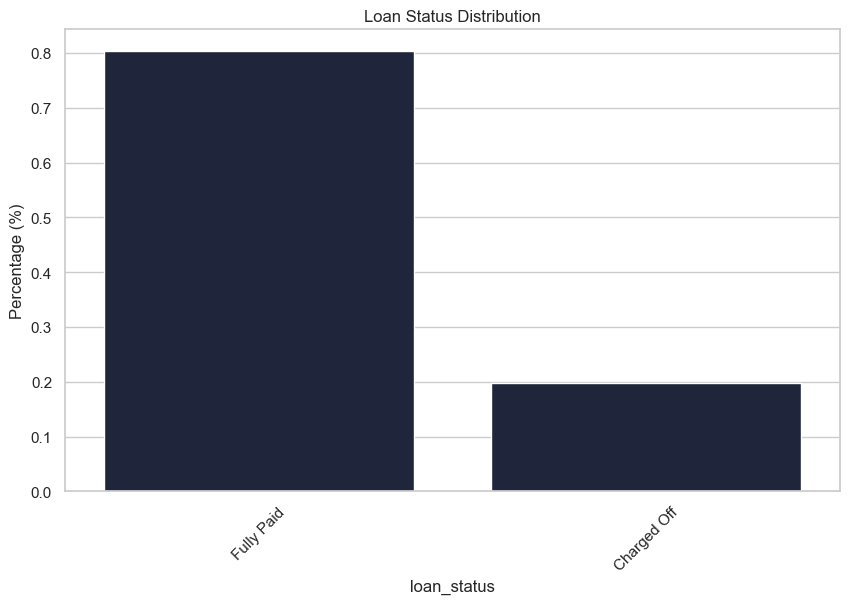

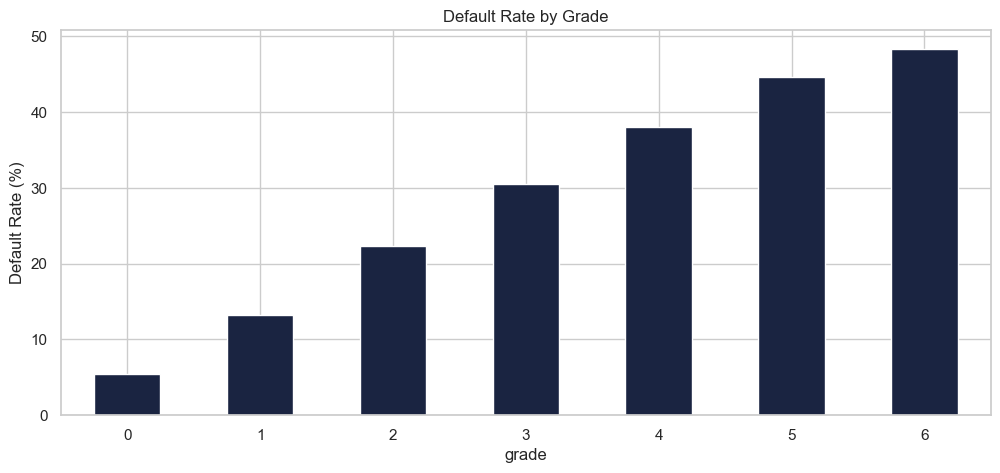


=== Grade Risk Analysis ===
loan_status  Charged Off  Fully Paid
grade                               
0               5.416734   94.583266
1              13.215125   86.784875
2              22.298944   77.701056
3              30.452436   69.547564
4              38.017872   61.982128
5              44.599303   55.400697
6              48.373984   51.626016


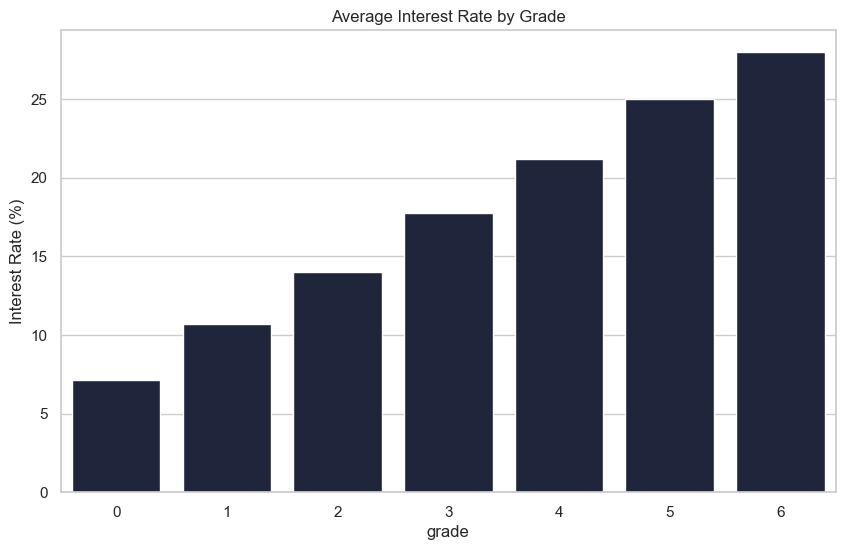


=== Interest Rate by Grade ===
grade
0     7.112639
1    10.678254
2    14.006852
3    17.720783
4    21.180621
5    24.984890
6    27.967602
Name: int_rate, dtype: float64


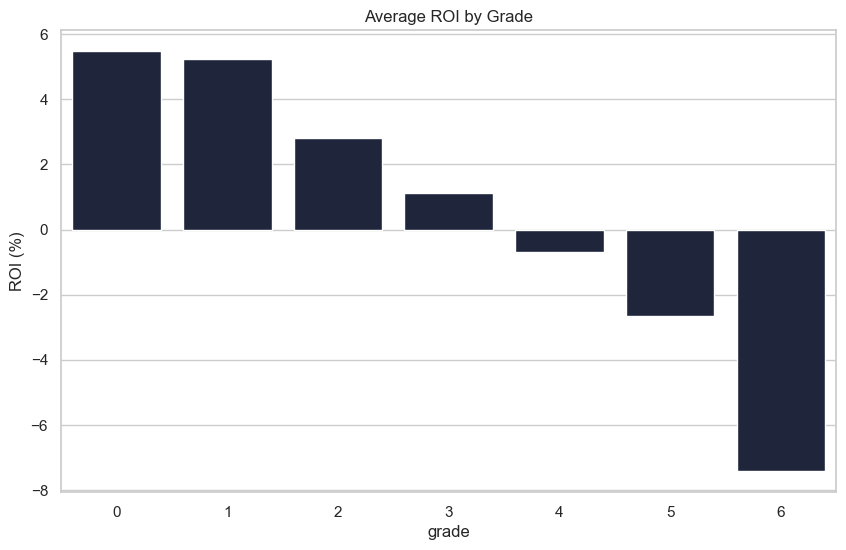


=== ROI by Grade ===
grade
6   -7.421585
5   -2.652741
4   -0.698034
3    1.126576
2    2.796909
1    5.227871
0    5.475937
Name: roi_percentage, dtype: float64


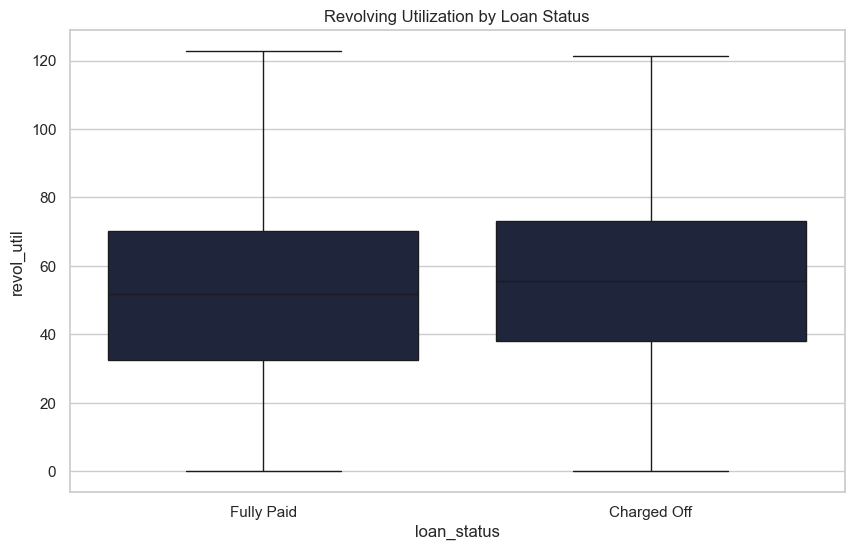


=== Top Correlations with Loan Status ===
loan_status_binary         1.000000
collection_recovery_fee    0.464099
grade                      0.265558
int_rate                   0.262572
term                       0.178206
recent_credit_activity     0.120166
acc_open_past_24mths       0.105148
debt_burden_risk_score     0.082046
debt_to_income_ratio       0.071754
dti                        0.071754
Name: loan_status_binary, dtype: float64

Action: Focus on strongly correlated features for risk assessment


{'default_rate': np.float64(0.197),
 'risk_by_grade': grade
 6    48.373984
 5    44.599303
 4    38.017872
 3    30.452436
 2    22.298944
 1    13.215125
 0     5.416734
 Name: Charged Off, dtype: float64,
 'grade_roi': grade
 6   -7.421585
 5   -2.652741
 4   -0.698034
 3    1.126576
 2    2.796909
 1    5.227871
 0    5.475937
 Name: roi_percentage, dtype: float64,
 'default_correlations': loan_status_binary         1.000000
 collection_recovery_fee    0.464099
 grade                      0.265558
 int_rate                   0.262572
 term                       0.178206
 recent_credit_activity     0.120166
 acc_open_past_24mths       0.105148
 debt_burden_risk_score     0.082046
 debt_to_income_ratio       0.071754
 dti                        0.071754
 Name: loan_status_binary, dtype: float64,
 'missing_values_pct': dti                         0.020000
 revol_util                  0.060000
 total_rev_hi_lim            4.962857
 acc_open_past_24mths        3.425714
 avg_cur_bal     

In [75]:
do_eda(df)


Highly correlated features (|correlation| > 0.8):
loan_amnt -- funded_amnt: 1.000
loan_amnt -- installment: 0.953
funded_amnt -- installment: 0.954
int_rate -- grade: 0.954
dti -- debt_to_income_ratio: 1.000
dti -- debt_burden_risk_score: 0.871
delinq_2yrs -- delinq_ratio: 0.964
earliest_cr_line -- mo_sin_old_rev_tl_op: 0.905
earliest_cr_line -- credit_history_length: 1.000
fico_range_low -- fico_range_high: 1.000
open_acc -- total_credit_lines: 0.888
revol_bal -- total_rev_hi_lim: 0.824
revol_util -- bc_util: 0.853
revol_util -- total_credit_util: 0.980
revol_util -- available_credit_ratio: -0.830
revol_util -- revol_util_rate: 1.000
bc_open_to_buy -- total_bc_limit: 0.845
bc_util -- total_credit_util: 0.836
bc_util -- available_credit_ratio: -0.966
bc_util -- revol_util_rate: 0.853
mo_sin_old_rev_tl_op -- credit_history_length: 0.905
num_bc_tl -- total_credit_lines: 0.849
debt_burden_ratio -- payment_to_income: 1.000
debt_burden_ratio -- loan_to_income: 0.973
payment_to_income -- lo

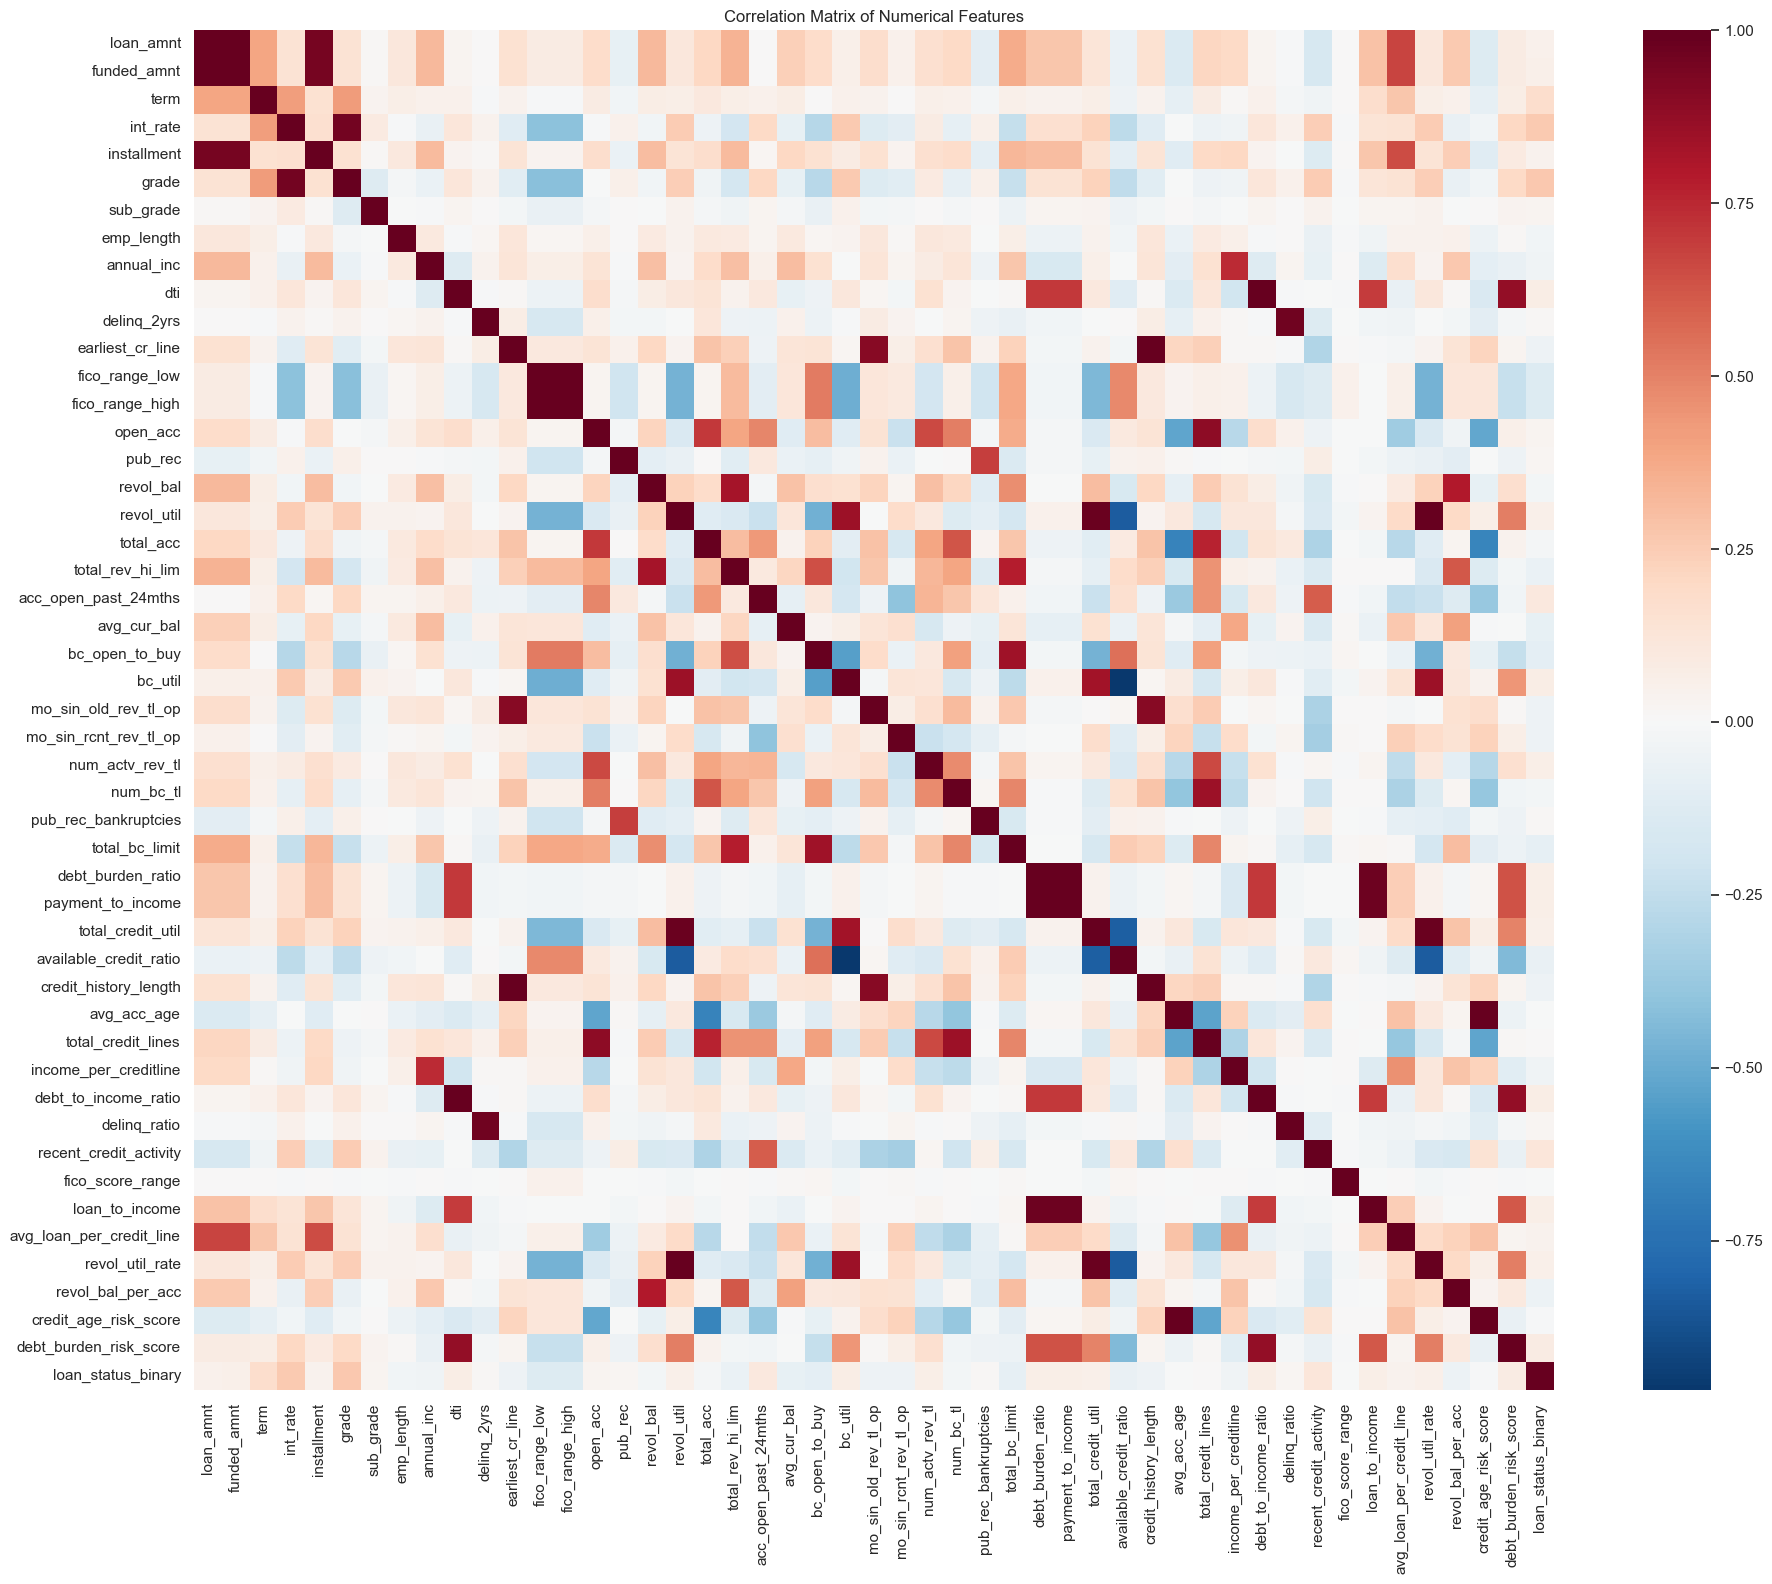

In [76]:
excluded_cols = ['net_profit_loss', 'roi_percentage', 'total_pymnt', 'collection_recovery_fee']
plot_feature_correlation(df, excluded_cols)

In [77]:
X, y, y_additionnal = prepare_model_data(df, excluded_cols)
# Usage
X_train, X_test, y_train, y_test, y_add_train, y_add_test = split_data(X, y, y_additionnal)
# Train model with k-fold cross validation
models, scores, feature_importance_df, oof_predictions, test_predictions, accuracy_threshold, profit_threshold, auc_threshold, precision_threshold = improved_kfold_lightgbm(
	X_train, 
	y_train,
	X_test, 
	num_folds=5,
	stratified=True
)



Features shape: (35000, 52)
Target shape: (35000,)
Target shape: (35000, 4)
Training set shapes:
X_train: (28000, 52)
y_train: (28000,)
y_add_train: (28000, 4)

Test set shapes:
X_test: (7000, 52)
y_test: (7000,)
y_add_test: (7000, 4)
Fold 1
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[276]	training's auc: 0.754975	valid_1's auc: 0.715859
Fold 1 ROC AUC: 0.7159
Fold 2
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.714313	valid_1's auc: 0.719315
Fold 2 ROC AUC: 0.7193
Fold 3
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[331]	training's auc: 0.761789	valid_1's auc: 0.720998
Fold 3 ROC AUC: 0.7210
Fold 4
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[516]	training's auc: 0.779464	valid_1's auc: 0.716879
Fold 4 ROC AUC: 0.7169
Fold 5
Training until validation scores don


=== ROI Threshold (0.3373) Analysis ===
Approved Loans: 6,416 (91.7% of total)
Total Profit: $3,377,487.59
Average ROI: 3.86%
Default Rate: 17.28%


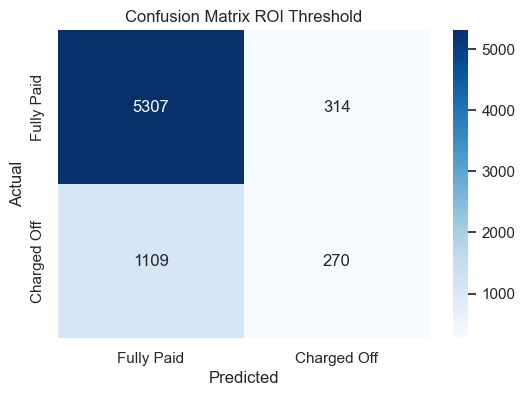


=== AUC Threshold (0.1971) Analysis ===
Approved Loans: 4,106 (58.7% of total)
Total Profit: $3,054,480.30
Average ROI: 5.69%
Default Rate: 11.15%


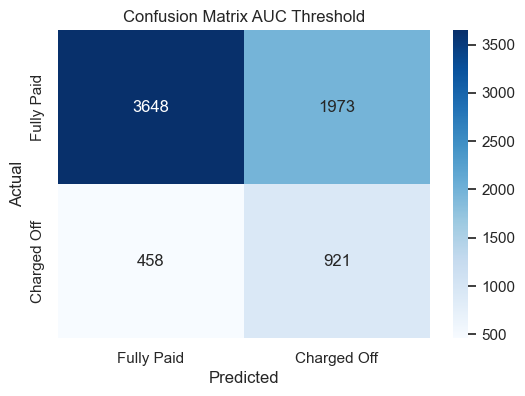


=== Accuracy Threshold (0.4699) Analysis ===
Approved Loans: 6,937 (99.1% of total)
Total Profit: $2,771,289.23
Average ROI: 3.20%
Default Rate: 19.36%


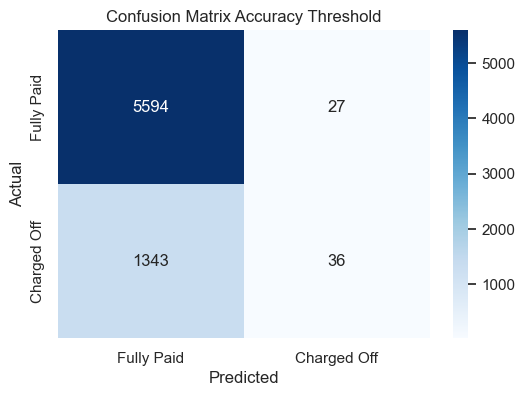


=== Precision Threshold (0.6024) Analysis ===
Approved Loans: 7,000 (100.0% of total)
Total Profit: $2,631,709.79
Average ROI: 3.06%
Default Rate: 19.70%


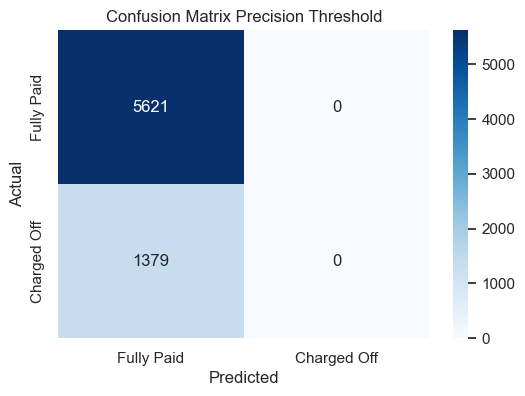

In [78]:
threshold_confusion_matrix()

In [79]:
16959983.13 / 357095175.0

0.04749429372715551

In [80]:
y_add_test = pd.concat([X_test['loan_amnt'], y_add_test], axis = 1).drop(columns ='collection_recovery_fee')
y_add_train = pd.concat([X_train['loan_amnt'], y_add_train], axis = 1).drop(columns ='collection_recovery_fee')

In [83]:
# find profit threshold on test data
test_accuracy_threshold, test_profit_threshold, test_precision_threshold = find_profit_and_accuracy_threshold(y_test, test_predictions, y_add_test)

In [ ]:
import joblib

# Save the models and test data

# Save the models
for i, model in enumerate(models):
	model.save_model(f'data/model2_fold_{i}.txt')

# Save test data and thresholds
joblib.dump({
	'y_test': y_test,
	'y_add_test': y_add_test,
	'y_train': y_train,
	'y_add_train': y_add_train,
	'test_predictions': test_predictions,
	'train_predictions': oof_predictions,
	'PROFIT_threshold': profit_threshold, 
	'test_PROFIT_threshold': test_profit_threshold, 
	'AUC_threshold': auc_threshold,
	'ACCURACY_threshold': accuracy_threshold,
	'PRECISION_threshold': precision_threshold
}, 'data/data2.joblib')

print("Models and test data saved successfully!")

Models and test data saved successfully!


In [82]:
if KAGGLE == True:
	# Save the filtered dataframe to a Parquet file
	df.reset_index()[dtypes_dict.keys()].to_parquet('data/reduced_loan_data.parquet', index=False)

	print("Filtered dataframe saved successfully in Parquet format!")
else: 
	print("Kaggle is False")

Filtered dataframe saved successfully in Parquet format!
